In [154]:
import tensorflow as tf
import pandas
import numpy as np
import  matplotlib.pyplot as plt
import re
import math
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# Гиперпараметры

In [155]:
vocab_size = 4000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<word>'
training_portion = 0.7
num_epochs = 20

## Считываем данные из файла

In [156]:
data_frame = pandas.read_excel('text.xlsx')
data_frame.head()

,description,name
0,"<p>первый подъезд, не убирают от слова совсем!...",Несвоевременная (некачественная) уборка мест о...
1,<p>Дорожное покрытие внутридворовой дороги по ...,Нарушено дорожное покрытие (ямы) на дорогах в ...
2,"<p>Добрый день, в п. Батрацкая Дача очень редк...",Несвоевременная (некачественная) очистка дворо...
3,<p>Добрый день. &nbsp;В доме по адресу Садовая...,Длительное неисполнение заявок управляющей ком...
4,<p>Хочется обратить внимание транспортного отд...,Нарушение графика движения при осуществлении м...


## Функция удаления тегов и посторонних символов

In [157]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

## Формирование набора данных, удаление пропущенных строк и объединение строк

In [158]:
descriptions = []
labels = []
for index in range(len(data_frame)):
    try:
        if math.isnan(data_frame.name[index]):
            try:
                if math.isnan(data_frame.description[index]):
                    continue
            except:
                val+=cleanhtml(data_frame.description[index])
    except:
        if index > 0:
            descriptions.append(val)
            labels.append(label)
        label = cleanhtml(data_frame.name[index])
        val = cleanhtml(data_frame.description[index])
descriptions.append(val)
labels.append(label)

In [159]:
print(len(data_frame))
print(len(descriptions))
print(len(labels))

9981
9465
9465


## Создание словаря категорий

In [160]:
label_dictionary = {}
for label in labels:
    if label not in label_dictionary:
        label_dictionary[label]=len(label_dictionary)

size_of_label = len(label_dictionary)
print('Количество уникальных меток', size_of_label)

Количество уникальных меток 161


## Формирование набора меток по категориям

In [161]:
categorical_labels = []
for label in labels:
    categorical_labels.append(label_dictionary[label])


categorical_labels=np.array(categorical_labels)
print(categorical_labels[:10])
print(categorical_labels.shape)

[0 1 2 3 4 5 6 6 7 1]
(9465,)


## Формирование обучающего и проверочного набора данных

In [162]:
train_size = int(len(descriptions) * training_portion)

train_descriptions = descriptions[0: train_size]
train_labels = categorical_labels[0: train_size]

validation_descriptions= descriptions[train_size:]
validation_labels = categorical_labels[train_size:]


print(len(train_descriptions))
print(len(train_labels))
print(len(validation_descriptions))
print(len(validation_labels))

6625
6625
2840
2840


## Токенизация данных

In [163]:
description_tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
description_tokenizer.fit_on_texts(train_descriptions)
description_word_index = description_tokenizer.word_index
dict(list(description_word_index.items())[0:5])

{'<OOV>': 1, 'и': 2, 'на': 3, 'в': 4, 'с': 5}

In [164]:
train_sequences = description_tokenizer.texts_to_sequences(train_descriptions)
print(train_sequences[:2])

[[875, 201, 7, 1588, 8, 1945, 660, 2429, 96, 1, 2, 50, 92, 1, 87, 284, 24, 647, 898, 30, 1, 786, 6, 1, 1, 118, 50, 160, 1278, 202, 1, 146, 92, 32, 19, 23, 1832, 410], [361, 182, 1, 86, 12, 148, 3, 1, 5, 86, 25, 140, 3, 266, 661, 408, 141, 662, 497, 3680, 69, 207, 4, 1589, 1, 181, 344, 2, 925, 1, 1026, 139, 115, 4, 2657, 1445, 303, 344, 1, 1, 19, 2085, 926, 34, 30, 420, 38, 34, 1, 4, 804, 145, 1, 510, 38, 2, 30, 1, 12, 1062, 3681, 38, 34, 733, 3682, 144, 1, 2086, 1833, 1, 1027, 44, 344]]


In [165]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))
print(len(train_padded))
print(train_padded.shape)

38
200
6625
(6625, 200)


In [166]:
validation_sequences = description_tokenizer.texts_to_sequences(validation_descriptions)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

2840
(2840, 200)


In [167]:
print(train_labels[:3])

[0 1 2]


## Проверка, процесс декодирования

In [168]:
reverse_word_index = dict([(value, key) for (key, value) in description_word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[1]))
print('---')
print(train_descriptions[1])

дорожное покрытие <OOV> дороги по адресу на <OOV> с дороги проспекта победы на м н королёва между домами 29 29а 4 находится в плачевном <OOV> состоянии ямы и неровности <OOV> безопасность дорожного движения в дождливую погоду дорога ямы <OOV> <OOV> что создает опасность как для автомобилей так как <OOV> в такие можно <OOV> авто так и для <OOV> по тротуару прохожих так как большая вероятность быть <OOV> той самой <OOV> водой из ямы ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
Дорожное покрытие внутридворовой дороги по адресу: на съезде с дороги проспекта Победы на м-н Королёва между домами 29, 29а,4 находится в плачевном разбитом состоянии. Ямы и неровности снижают безопасность дорожного движения. В дождливую погоду дорога (ямы) покрыта лужами, что создает опасность как для авт

## Создание обучающей модели

In [169]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(size_of_label, activation='softmax')
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 64)          256000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 161)               10465     
                                                                 
Total params: 340,769
Trainable params: 340,769
Non-trainable params: 0
_________________________________________________________________


## Компиляция и обучение модели

In [170]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)

Epoch 1/20
208/208 - 25s - loss: 2.3587 - accuracy: 0.5663 - val_loss: 1.6121 - val_accuracy: 0.6627 - 25s/epoch - 120ms/step
Epoch 2/20
208/208 - 20s - loss: 1.8310 - accuracy: 0.5736 - val_loss: 1.5062 - val_accuracy: 0.6616 - 20s/epoch - 97ms/step
Epoch 3/20
208/208 - 20s - loss: 1.7380 - accuracy: 0.5796 - val_loss: 1.4509 - val_accuracy: 0.6630 - 20s/epoch - 97ms/step
Epoch 4/20
208/208 - 20s - loss: 1.6542 - accuracy: 0.6023 - val_loss: 1.4569 - val_accuracy: 0.6697 - 20s/epoch - 97ms/step
Epoch 5/20
208/208 - 20s - loss: 1.5413 - accuracy: 0.6237 - val_loss: 1.4901 - val_accuracy: 0.6708 - 20s/epoch - 96ms/step
Epoch 6/20
208/208 - 20s - loss: 1.4238 - accuracy: 0.6548 - val_loss: 1.4387 - val_accuracy: 0.6901 - 20s/epoch - 98ms/step
Epoch 7/20
208/208 - 20s - loss: 1.3001 - accuracy: 0.6833 - val_loss: 1.3926 - val_accuracy: 0.6968 - 20s/epoch - 97ms/step
Epoch 8/20
208/208 - 20s - loss: 1.1859 - accuracy: 0.7057 - val_loss: 1.4131 - val_accuracy: 0.7173 - 20s/epoch - 96ms/step

## Вывод графического результата

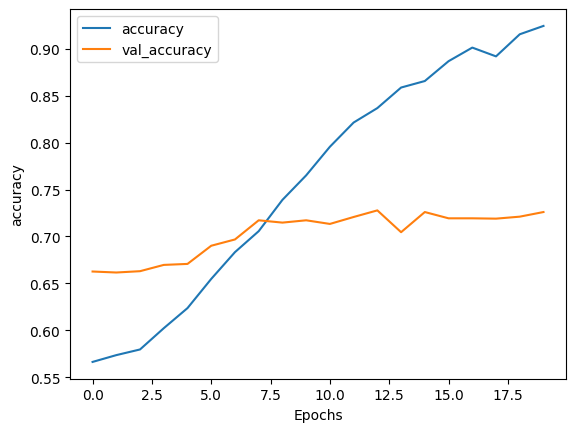

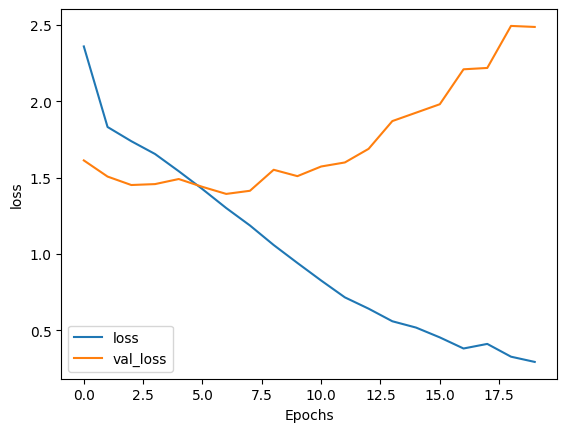

In [171]:
def plot_graphs(history, string):
 plt.plot(history.history[string])
 plt.plot(history.history['val_'+string])
 plt.xlabel("Epochs")
 plt.ylabel(string)
 plt.legend([string, 'val_'+string])
 plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")